In [1]:
import pandas as pd
import numpy as np
import time
import datetime
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale

# Summary

<b>Градиентный бустинг:</b><ol><li>12 признаков имеют пропуски (см. список ниже). В некоторых случаях это может быть объяснено отсутствием наступившего события (например, first_blood_time или first_blood_team).</li><li>Целевая переменная содержится в столбце</li><li>Кросс-валидация для градиентого бустинга на 30 деревьях проходит примерно за 5минут (на моем ПК). AUC на кросс-валидации ~0.70.</li><li>Больше 30 деревьев в градиентном бустинге имеет смысл использовать, но прирост качества будет "небольшим". Для ускорения можно использовать стохастический градиентный бустинг (т.е. добавить элементы бэггинга - обучаться на каждом шаге на случайной подвыборке).</li></ol><br>
<b>Логистическая регрессия:</b><ol>
<li>Логистическая регрессия ожидаемо работает существенно быстрее градиентного бустинга. При C=1 ROC-AUC = 0.7165 (качество чуть лучше, чем у градиентного бустинга). Нужно отметить, что это достигнуто в том числе за счет нормировки фичей.</li><li>Если убрать категориальные признаки, качество не меняется (в чевертом знаке, объясняет случайными флуктуациями). Категориальные фичи не участвовали в построении логистической регрессии.</li><li>В игре 108 уникальных героев</li><li>После бинаризации категориальных признаков качество ожидаемо возрастает (до ~0.7519)</li><li>Минимальное значение предсказания 0.01, максимальное - 1.0</li></ol>
<b>Все выкладки и результаты - см. ниже</b>

# Gradient boosting

In [2]:
features = pd.read_csv('./features.csv', index_col='match_id')

In [3]:
#drop features that are not represented in the test set
features_final = ['duration',  'tower_status_radiant', 'tower_status_dire', 
                  'barracks_status_radiant', 'barracks_status_dire']
for f in features_final:
    features = features.drop(f, axis = 1)

In [4]:
#features with missing values
for f in features.columns:
    tmp = 1.0*features[f].isnull().sum()/features[f].count()
    if tmp > 0:
        print "Features {0} has {1:.2%} missing values".format(f, tmp)
        features[f] = features[f].fillna(0)
        
#first_blood features might have missing values in case when there was no blood during the game (= it can be an additional binary feature)

Features first_blood_time has 25.17% missing values
Features first_blood_team has 25.17% missing values
Features first_blood_player1 has 25.17% missing values
Features first_blood_player2 has 82.62% missing values
Features radiant_bottle_time has 19.24% missing values
Features radiant_courier_time has 0.72% missing values
Features radiant_flying_courier_time has 39.40% missing values
Features radiant_first_ward_time has 1.92% missing values
Features dire_bottle_time has 19.91% missing values
Features dire_courier_time has 0.70% missing values
Features dire_flying_courier_time has 36.69% missing values
Features dire_first_ward_time has 1.91% missing values


In [6]:
#our target variable is radiant_win (0,1)
Y = features.radiant_win
X = features[[c for c in features.columns if c <> 'radiant_win']]
kfl = KFold(Y.size, n_folds=5, shuffle=True, random_state=42)

In [8]:
scores = []
k_range = [10, 20, 30]
l_range = [0.1, 0.4, 0.45, 0.48, 0.49, 0.5, 0.51, 0.52, 0.55, 0.6, 1.0]
for i in k_range:
    for l in l_range:
        clf =  GradientBoostingClassifier(n_estimators = i, learning_rate = l)
        start_time = datetime.datetime.now()
        scores.append({'estimators': i, 
                       'learnig rate': l,
                       'score': cross_val_score(clf, X, Y, cv=kfl, scoring='roc_auc').mean()})
        print 'Time elapsed:', datetime.datetime.now() - start_time
#for n_estimators = 30 cross-validation took ~5 min for one iteration

Time elapsed: 0:01:06.498000
Time elapsed: 0:01:07.768000
Time elapsed: 0:01:44.712000
Time elapsed: 0:01:27.300000
Time elapsed: 0:01:11.681000
Time elapsed: 0:01:19.680000
Time elapsed: 0:01:32.476000
Time elapsed: 0:01:24.802000
Time elapsed: 0:01:01.005000
Time elapsed: 0:00:58.786000
Time elapsed: 0:01:01.018000
Time elapsed: 0:02:05.731000
Time elapsed: 0:02:40.003000
Time elapsed: 0:01:59.898000
Time elapsed: 0:02:10.535000
Time elapsed: 0:02:30.005000
Time elapsed: 0:01:51.658000
Time elapsed: 0:02:11.807000
Time elapsed: 0:02:24.954000
Time elapsed: 0:01:49.143000
Time elapsed: 0:01:49.186000
Time elapsed: 0:01:53.659000
Time elapsed: 0:02:44.575000
Time elapsed: 0:02:42.295000
Time elapsed: 0:03:12.959000
Time elapsed: 0:02:43.645000
Time elapsed: 0:03:01.920000
Time elapsed: 0:02:43.425000
Time elapsed: 0:02:45.455000
Time elapsed: 0:03:07.630000
Time elapsed: 0:02:39.213000
Time elapsed: 0:03:04.863000
Time elapsed: 0:02:37.417000


In [10]:
tmp = max([s['score'] for s in scores])
print "The best score for is.nan = 0 is {0}".format([s for s in scores if s['score'] == tmp])

The best score for is.nan = 0 is [{'score': 0.70334164350763362, 'learnig rate': 0.49, 'estimators': 30}]


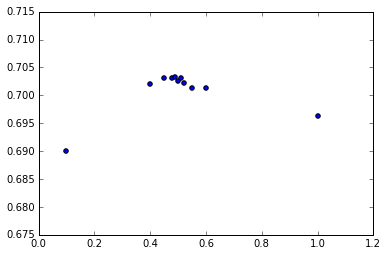

The best score for is.nan = 0 is [{'score': 0.70334164350763362, 'learnig rate': 0.49, 'estimators': 30}]


In [11]:
plt.figure(1)
plt.scatter([s['learnig rate'] for s in scores if s['estimators'] == 30], [s['score'] for s in scores if s['estimators'] == 30])
plt.show()
tmp = max([s['score'] for s in scores if s['estimators'] == 30])
print "The best score for is.nan = 0 is {0}".format([s for s in scores if s['score'] == tmp and s['estimators'] == 30])

# Logistic regression

In [14]:
#Logistic regression
scores_lr1 = []
C_range = np.linspace(0, 1, 50)
C_range = [0.01, 0.1, 0.5, 1.0, 10, 50, 100]
kfl = KFold(Y.size, n_folds=5, shuffle=True, random_state=42)
X_norm = scale(X, axis=0)
for i in C_range[1:]:
    print i
    clf_lr = LogisticRegression(penalty = 'l2', C=i)
    start_time = datetime.datetime.now()
    scores_lr1.append({"C": i,
                    "score": cross_val_score(clf_lr, X_norm, Y, cv=kfl, scoring='roc_auc').mean()})
    print 'Time elapsed:', datetime.datetime.now() - start_time

0.1
Time elapsed: 0:00:35.454000
0.5
Time elapsed: 0:00:51.273000
1.0
Time elapsed: 0:01:05.641000
10
Time elapsed: 0:00:46.545000
50
Time elapsed: 0:00:46.456000
100
Time elapsed: 0:00:46.183000


In [15]:
tmp = max([s['score'] for s in scores_lr1])
print "The best score for is.nan = 0 is {0}".format([s for s in scores_lr1 if s['score'] == tmp])

The best score for is.nan = 0 is [{'C': 0.1, 'score': 0.71652715290247593}]


In [16]:
#Logistic regression without categorical features
features_cat = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 
                'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

In [18]:
Y = features.radiant_win
X = features[[c for c in features.columns if (c not in features_cat) and (c <> 'radiant_win')]]
kfl = KFold(Y.size, n_folds=5, shuffle=True, random_state=42)
scores_lr2 = []
C_range = [0.01, 0.1, 0.5, 1.0, 10, 50, 100]
X_norm = scale(X, axis=0)
for c in C_range:
    clf_lr = LogisticRegression(penalty = 'l2', C = c)
    start_time = datetime.datetime.now()
    scores_lr2.append({"C": c,
                    "score": cross_val_score(clf_lr, X_norm, Y, cv=kfl, scoring='roc_auc').mean()})
    print 'Time elapsed:', datetime.datetime.now() - start_time

Time elapsed: 0:00:45.187000
Time elapsed: 0:00:42.348000
Time elapsed: 0:00:42.695000
Time elapsed: 0:00:51.203000
Time elapsed: 0:00:57.682000
Time elapsed: 0:00:59.235000
Time elapsed: 0:00:58.586000


In [19]:
tmp = max([s['score'] for s in scores_lr2])
print "The best score for is.nan = 0 is {0}".format([s for s in scores_lr2 if s['score'] == tmp])

The best score for is.nan = 0 is [{'C': 0.01, 'score': 0.71655938644491324}]


In [20]:
hero_features = ['r1_hero', 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero', 
                'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']
heros =[]
for f in hero_features:
    heros = np.concatenate((heros,features[f].unique()), axis=1)
heros = np.unique(heros)
print "There are {0} unique heros in the game".format(len(heros))

There are 108 unique heros in the game


In [21]:
X_pick = np.zeros((features.shape[0], len(heros)))
for i, match_id in enumerate(features.index):
    for p in xrange(5):
        X_pick[i, np.argwhere(heros == features.ix[match_id, 'r%d_hero' % (p+1)])[0][0]] = 1
        X_pick[i, np.argwhere(heros == features.ix[match_id, 'd%d_hero' % (p+1)])[0][0]] = -1
X_pick = pd.DataFrame(X_pick)
X_pick.columns = ["hero=%d" % i for i in X_pick.columns]
X_pick.index = features.index

In [22]:
Y = features.radiant_win
X = features[[c for c in features.columns if (c not in features_cat) and (c <> 'radiant_win')]]
#include only N-1 dummy features
X = pd.concat([X,X_pick.loc[:, X_pick.columns[1:]]], axis = 1)
kfl = KFold(Y.size, n_folds=5, shuffle=True, random_state=42)
scores_lr3 = []
C_range = [0.01, 0.1, 0.5, 1.0, 10, 50, 100]
X_norm = scale(X, axis=0)
for c in C_range:
    clf_lr = LogisticRegression(penalty = 'l2', C = c)
    start_time = datetime.datetime.now()
    scores_lr3.append({"C": c,
                    "score": cross_val_score(clf_lr, X_norm, Y, cv=kfl, scoring='roc_auc').mean()})
    print 'Time elapsed:', datetime.datetime.now() - start_time

Time elapsed: 0:01:41.577000
Time elapsed: 0:01:50.863000
Time elapsed: 0:01:58.599000
Time elapsed: 0:01:51.414000
Time elapsed: 0:01:52.300000
Time elapsed: 0:01:51.757000
Time elapsed: 0:01:51.239000


In [23]:
tmp = max([s['score'] for s in scores_lr3])
print "The best score for is.nan = 0 is {0}".format([s for s in scores_lr3 if s['score'] == tmp])

The best score for is.nan = 0 is [{'C': 0.01, 'score': 0.75192899100206279}]


In [25]:
clf = LogisticRegression(penalty = 'l2', C = 0.01)
model = clf.fit(X_norm, Y)

# Submission

In [26]:
features_test = pd.read_csv('./features_test.csv', index_col='match_id')

In [27]:
X_test = features_test[[c for c in features_test.columns if (c not in features_cat) and (c <> 'radiant_win')]]

In [29]:
for f in features_test.columns:
    tmp = 1.0*features_test[f].isnull().sum()/features_test[f].count()
    if tmp > 0:
        print "Features {0} has {1:.2%} missing values".format(f, tmp)
        features_test[f] = features_test[f].fillna(0)

Features first_blood_time has 26.07% missing values
Features first_blood_team has 26.07% missing values
Features first_blood_player1 has 26.07% missing values
Features first_blood_player2 has 82.52% missing values
Features radiant_bottle_time has 20.27% missing values
Features radiant_courier_time has 0.74% missing values
Features radiant_flying_courier_time has 39.74% missing values
Features radiant_first_ward_time has 1.96% missing values
Features dire_bottle_time has 19.83% missing values
Features dire_courier_time has 0.76% missing values
Features dire_flying_courier_time has 35.75% missing values
Features dire_first_ward_time has 1.55% missing values


In [30]:
X_pick_test = np.zeros((features_test.shape[0], len(heros)))
for i, match_id in enumerate(features_test.index):
    for p in xrange(5):
        X_pick_test[i, np.argwhere(heros == features_test.ix[match_id, 'r%d_hero' % (p+1)])[0][0]] = 1
        X_pick_test[i, np.argwhere(heros == features_test.ix[match_id, 'd%d_hero' % (p+1)])[0][0]] = -1
X_pick_test = pd.DataFrame(X_pick_test)
X_pick_test.columns = ["hero=%d" % i for i in X_pick_test.columns]
X_pick_test.index = features_test.index

In [32]:
X_test = features_test[[c for c in features_test.columns if (c not in features_cat) and (c <> 'radiant_win')]]
X_test = pd.concat([X_test,X_pick_test.loc[:, X_pick_test.columns[1:]]], axis = 1)
X_test_norm = scale(X_test, axis=0)
Y_pred = model.predict(X_test_norm)
Y_pred_prob = model.predict_proba(X_test_norm)

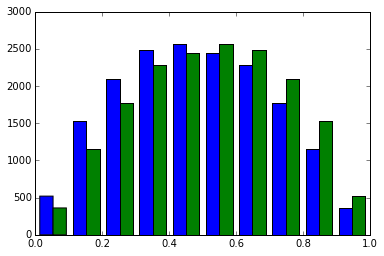

In [33]:
plt.figure(1)
plt.hist(Y_pred_prob)
plt.show()

In [34]:
Y_pred = [i[1] for i in Y_pred_prob]
res = pd.DataFrame(Y_pred)
res.index = X_test.index
res.columns = ['radiant_win']

In [41]:
print "Минимальное {0:.2f} и максимальное {1:.2f} предсказание на тестовой выборке".format(min(Y_pred), max(Y_pred))

Минимальное 0.01 и максимальное 1.00 предсказание на тестовой выборке


In [39]:
res.to_csv('./submission.csv')